In [2]:
using Base: @kwdef
#using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, PyPlot, ProgressMeter
#using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter
#using BenchmarkTools; @btime
rc("axes.spines", top=false, right=false)

In [66]:
function isi_neuron(dt, T; n_neurons=10, fr=2)
    # dt, T: sec
    nt = round(Int, T/dt) # number of timesteps    
    spikes = rand(nt, n_neurons) .< fr*dt #*1e-3
    return 1.0*spikes
end

isi_neuron (generic function with 1 method)

In [258]:
n_neurons_exc = 800*2
n_neurons_inh = 200*2
dt = 1e-4 # sec
T = 10
spikes_exc = isi_neuron(dt, T, n_neurons=n_neurons_exc, fr=2);
spikes_inh = isi_neuron(dt, T, n_neurons=n_neurons_inh, fr=5);

In [81]:
# 二重指数関数型シナプス
function double_exp_synapse(spikes, dt, T; tr=1e-4, td=2e-3)
    nt, n_neurons = size(spikes)
    r_double, hr = zero(spikes), zero(spikes)
    for t in 1:nt-1
        r_double[t+1, :] = r_double[t, :]*(1-dt/tr) + hr[t, :]*dt
        hr[t+1, :] = hr[t, :]*(1-dt/td) + spikes[t, :]/(tr*td)
    end
    return r_double
end

double_exp_synapse (generic function with 2 methods)

In [259]:
r_exc = double_exp_synapse(spikes_exc, dt, T, tr=1e-4, td=2e-3);
r_inh = double_exp_synapse(spikes_inh, dt, T, tr=5e-4, td=1e-2);

In [260]:
g_exc = sum(r_exc, dims=2);
g_inh = sum(r_inh, dims=2);

In [261]:
ei_ratio = sum(g_exc) / sum(g_inh)

1.5808125821056749

In [262]:
v_rest = -65
v_rev_exc = 0
v_rev_inh = -80

-80

In [263]:
lfps = []
for target_ei_ratio in [2, 6]
    alpha_inh = target_ei_ratio * ei_ratio
    lfp = ((v_rest - v_rev_exc) * g_exc + (v_rest - v_rev_inh) * alpha_inh * g_inh) / (n_neurons_exc+n_neurons_inh);
    push!(lfps, lfp)
end

In [264]:
lfps2 = cat(lfps..., dims=2)'

2×100000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  -16.25  -15.4375  -14.1914  …  -78.826    -89.5441  -83.4923
 0.0  0.0  0.0  -16.25  -15.4375  -13.2429       0.64974  -10.8608   -5.59405

In [176]:
using DSP

In [265]:
fs = 1/dt
psd_lfp1 = DSP.Periodograms.welch_pgram(vec(lfps2[1, :]), fs=fs)
psd_lfp2 = DSP.Periodograms.welch_pgram(vec(lfps2[2, :]), fs=fs)

DSP.Periodograms.Periodogram{Float64, AbstractFFTs.Frequencies{Float64}, Vector{Float64}}([2038.6298008490987, 33.82888514365858, 23.584362334699435, 18.719859608056105, 13.032131095085727, 18.4266987494975, 27.581425656809962, 35.31152440287629, 20.674887792189107, 18.702274531940866  …  0.002990006405781037, 0.0036672593088421753, 0.005482103894126164, 0.005076111195981173, 0.005426121654453982, 0.004094135149834189, 0.005371997513860336, 0.0051491287328394066, 0.0033178535556589207, 0.002282778073600195], [0.0, 0.8, 1.6, 2.4000000000000004, 3.2, 4.0, 4.800000000000001, 5.6000000000000005, 6.4, 7.2  …  4992.8, 4993.6, 4994.400000000001, 4995.200000000001, 4996.0, 4996.8, 4997.6, 4998.400000000001, 4999.200000000001, 5000.0])

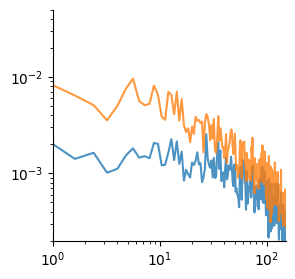

(0.0002, 0.05)

In [266]:
figure(figsize=(3,3))
loglog(psd_lfp1.freq, (psd_lfp1.power/sum(psd_lfp1.power)), alpha=0.8)
loglog(psd_lfp2.freq, (psd_lfp2.power/sum(psd_lfp2.power)), alpha=0.8)
xlim(1, 150)
ylim(2e-4, 5e-2)